## WHO GHO Indicators for Obesity Research

**Analysis of 3,039 available WHO indicators found 819 obesity-related indicators:**

| Category | Count | Key Examples |
|----------|-------|--------------|
| **Obesity Measures** | 29 | `NCD_BMI_30A` (adult obesity), `NCD_BMI_25A` (overweight), child malnutrition |
| **Physical Activity** | 18 | `NCD_PAC` (insufficient activity), PA guidelines, workplace initiatives |
| **Nutrition/Diet** | 76 | Minimum acceptable diet, food safety, unhealthy diet policies |
| **Diabetes/Glucose** | 22 | `NCD_GLUC_04` (raised blood glucose), diabetes testing, HbA1c |
| **Cardiovascular** | 27 | `BP_04` (hypertension), blood pressure, heart disease mortality |
| **Tobacco** | 249 | Tobacco use, advertising bans, tobacco control programs |
| **Alcohol** | 275 | Alcohol consumption, use disorders, BAC limits |
| **Socioeconomic** | 84 | Poverty (`CCO_1`), literacy, income inequality |
| **Geographic** | 13 | Urban/rural population, city coverage |
| **Healthcare** | 21 | Health expenditure, immunization coverage, financial protection |
| **Other** | 5 | Miscellaneous health indicators |

    "**Full list saved to:** `data/metadata/who_indicators_obesity_related.csv`\n",



In [1]:
# Setup for Google Colab
# Clone repository to Google Drive and point working directory to /code directory
# Uncomment and edit the lines below if running in Colab:

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/Obesity/code')  # Change this to your path


# Obesity — Data Collection

Download WHO Global Health Observatory indicator data, merge into a single CSV file.

**Quick Start:** Change `query` below to select indicators, then run all cells.

**Workflow:**
1. Define core indicators for filtering
2. Download indicators matching query
3. Save full dataset to `who_obesity_data.csv`
4. Filter to core indicators and save to `who_obesity_core_data.csv`

## Configuration & Setup

In [2]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Set default visualization style
sns.set_style('whitegrid')
sns.set_palette('deep')

# Query to search for obesity-related indicators
# Using descriptive keywords that appear in indicator  or codes
query = ('BMI|obesity|overweight|'
         'physical activity|'
         'diabetes|glucose|blood sugar|'
         'blood pressure|hypertension|'
         'cholesterol|'
         'tobacco|smoking|'
         'alcohol|'
         'salt|sodium|'
         'population|'
         'life expectancy|'
         'immunization|'
         'poverty|'
         'inequality|'
         'national income|gross national income|GNI')

print(f'Query: {query}')


Query: BMI|obesity|overweight|physical activity|diabetes|glucose|blood sugar|blood pressure|hypertension|cholesterol|tobacco|smoking|alcohol|salt|sodium|population|life expectancy|immunization|poverty|inequality|national income|gross national income|GNI


## Load Data 

In [3]:
import pandas as pd
import requests
import time
from glob import glob
import numpy as np
import os


# Load all available indicators
indicators_df = pd.read_csv('../data/metadata/who_indicators_all.csv')[['IndicatorCode', 'IndicatorName']].drop_duplicates()

# Load existing data
data_file = '../data/who_obesity_data.csv'
df = pd.read_csv(data_file)
print(f' Loaded existing data: {len(df):,} rows')

existing_codes = set(df['IndicatorCode'].unique())
print(f'  Existing: {len(existing_codes)} indicators')

# Filter by query
query_mask = (indicators_df['IndicatorName'].str.contains(query, case=False, na=False) | 
              indicators_df['IndicatorCode'].str.contains(query, case=False, na=False))

# Exclude existing indicators
new_df = indicators_df[query_mask][~indicators_df['IndicatorCode'].isin(existing_codes)]

selected_indicators = new_df.to_dict('records')

print(f'\nNew Indicators to Download: {len(selected_indicators)}')

/var/folders/n3/pcj4k0m94415fgwnccl63v5r0000gn/T/ipykernel_8027/1432921341.py:14: DtypeWarning: Columns (0,1,2,4,5,6,7,8,9,17,18,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


 Loaded existing data: 3,961,866 rows
  Existing: 993 indicators

New Indicators to Download: 0


/var/folders/n3/pcj4k0m94415fgwnccl63v5r0000gn/T/ipykernel_8027/1432921341.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_df = indicators_df[query_mask][~indicators_df['IndicatorCode'].isin(existing_codes)]


## Download Indicator Data

In [4]:
# Download indicator data
if len(selected_indicators) > 0:
    new_rows = []  # Collect new rows

    for idx, indicator in enumerate(selected_indicators, 1):
        code = indicator.get("IndicatorCode")
        name = indicator.get("IndicatorName", "")
        print(f"[{idx}/{len(selected_indicators)}] {code}...", end=" ")
    
        try:
            r = requests.get(f"https://ghoapi.azureedge.net/api/{code}", timeout=30)
            if r.status_code == 200:
                records = r.json().get("value", [])
            
                if len(records) == 0:
                    # Add dummy row with indicator info, other columns will be NA
                    dummy_row = {"IndicatorCode": code, "IndicatorName": name}
                    new_rows.append(dummy_row)
                    print("no data")
                else:
                    for rec in records:
                        rec["IndicatorCode"] = code
                        rec["IndicatorName"] = name
                    new_rows.extend(records)
                    print(f"{len(records)} records")
            else:
                print(f"Error {r.status_code}")
        except Exception as e:
            print(f"Error: {e}")
        time.sleep(0.2)
    
    # Append new rows to df
    if len(new_rows) > 0:
        downloaded_df = pd.DataFrame(new_rows)
        df = pd.concat([df, downloaded_df], ignore_index=True)
        print(f"\nAdded {len(new_rows):,} rows, {downloaded_df['IndicatorCode'].nunique()} indicators")
else:
    print("No new indicators to download")


No new indicators to download


## Save to CSV

In [5]:
# Save data - only when new indicators were downloaded
if len(selected_indicators) > 0:
    import os
    
    # Save to full dataset file (includes all existing + newly downloaded data)
    output_file = "../data/who_obesity_data.csv"
    df.to_csv(output_file, index=False)
    
    file_size_mb = os.path.getsize(output_file) / 1024 / 1024
    
    print(f"Saved: {len(df):,} rows, {df['IndicatorCode'].nunique()} indicators, {file_size_mb:.1f} MB")
else:
    print("No new data to save")

No new data to save


## Save Core Dataset

In [6]:
# Save Core Dataset

# Load core indicators from CSV
core_indicators_df = pd.read_csv('../data/metadata/who_indicators_obesity_core.csv')
all_core_codes = core_indicators_df['IndicatorCode'].tolist()

# Filter full dataset to only core indicators
core_df = df[df['IndicatorCode'].isin(all_core_codes)].copy()

# Save core data
core_output_file = "../data/who_obesity_core_data.csv"
core_df.to_csv(core_output_file, index=False)

print(f"Saved core dataset: {len(core_df):,} rows, {core_df['IndicatorCode'].nunique()} indicators")

Saved core dataset: 106,416 rows, 11 indicators


## View Results - All Data

In [7]:
# Full Dataset Overview Dashboard
import matplotlib.pyplot as plt
import seaborn as sns

print('=' * 80)
print('FULL DATASET OVERVIEW'.center(80))
print('=' * 80)

# Basic statistics
total_rows = len(df)
total_indicators = df['IndicatorCode'].nunique()
total_countries = df['SpatialDim'].nunique()
year_range = f"{df['TimeDim'].min():.0f} - {df['TimeDim'].max():.0f}"

print(f'\nData Summary:')
print(f'  Records: {total_rows:,}')
print(f'  Indicators: {total_indicators}')
print(f'  Countries/Regions: {total_countries}')
print(f'  Years: {year_range}')

# Data coverage
year_counts = df['TimeDim'].value_counts().sort_index()
print('\nTop 5 Years with Most Data:')
for year, count in year_counts.nlargest(5).items():
    print(f'  {year:.0f}: {count:,} records')

print('\n' + '=' * 80)

                             FULL DATASET OVERVIEW                              

Data Summary:
  Records: 3,961,866
  Indicators: 993
  Countries/Regions: 381
  Years: 1960 - 2030

Top 5 Years with Most Data:
  2012: 410,991 records
  2000: 326,301 records
  2014: 188,563 records
  2015: 187,253 records
  2010: 173,578 records



### Add Indicator Categories to Data Frame

In [8]:
# Load categorized indicators and join to main dataframe
indicators_cat = pd.read_csv('../data/metadata/who_indicators_obesity_related.csv')[['IndicatorCode', 'Category']]

# Join categories to df
df = df.join(indicators_cat.set_index('IndicatorCode'), on='IndicatorCode', how='left')


## View Results - Core Data

In [9]:
# Load and display core dataset
core_df = pd.read_csv('../data/who_obesity_core_data.csv')

# Load and join categories
indicators_cat = pd.read_csv('../data/metadata/who_indicators_obesity_related.csv')[['IndicatorCode', 'Category']]
core_df = core_df.join(indicators_cat.set_index('IndicatorCode'), on='IndicatorCode', how='left')

print('=' * 80)
print('CORE DATASET OVERVIEW'.center(80))
print('=' * 80)

# Basic statistics
print(f'\nData Summary:')
print(f'  Records: {len(core_df):,}')
print(f'  Indicators: {core_df["IndicatorCode"].nunique()}')
print(f'  Countries/Regions: {core_df["SpatialDim"].nunique()}')
print(f'  Years: {core_df["TimeDim"].min():.0f} - {core_df["TimeDim"].max():.0f}')

# Top years with data
year_counts = core_df['TimeDim'].value_counts().sort_index()
print('\nTop 5 Years with Most Data:')
for year, count in year_counts.nlargest(5).items():
    print(f'  {year:.0f}: {count:,} records')

# Recent data coverage
recent_years = core_df[core_df['TimeDim'] >= 2020]['TimeDim'].value_counts().sort_index()
print(f'\nRecent Data (2020+):')
print(f'  Records: {recent_years.sum():,} across {len(recent_years)} years')

print('\n' + '=' * 80)

/var/folders/n3/pcj4k0m94415fgwnccl63v5r0000gn/T/ipykernel_8027/4256019130.py:2: DtypeWarning: Columns (0,1,2,6,7,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  core_df = pd.read_csv('../data/who_obesity_core_data.csv')


                             CORE DATASET OVERVIEW                              

Data Summary:
  Records: 120,913
  Indicators: 11
  Countries/Regions: 212
  Years: 1960 - 2030

Top 5 Years with Most Data:
  2010: 4,508 records
  2021: 4,222 records
  2015: 4,132 records
  2020: 3,962 records
  2022: 3,947 records

Recent Data (2020+):
  Records: 13,121 across 5 years



## Merging datasets from different indicators and ploting HeatMap 

  CountryCode    Year  NCD_BMI_30A  Adult_curr_tob_use  CCO_1  M_Est_smk_curr  \
0         WSM  1991.0    38.792646                 NaN    NaN             NaN   
1         BRN  2006.0    18.341002                 NaN    NaN             NaN   

     NCD_PAA    NCD_PAC RS_193  RS_576  SA_0000001400 NCD_CCS_SaltPol  
0        NaN        NaN    NaN     NaN       2.190000             NaN  
1  27.775627  25.608099    NaN     NaN       0.605844             NaN  


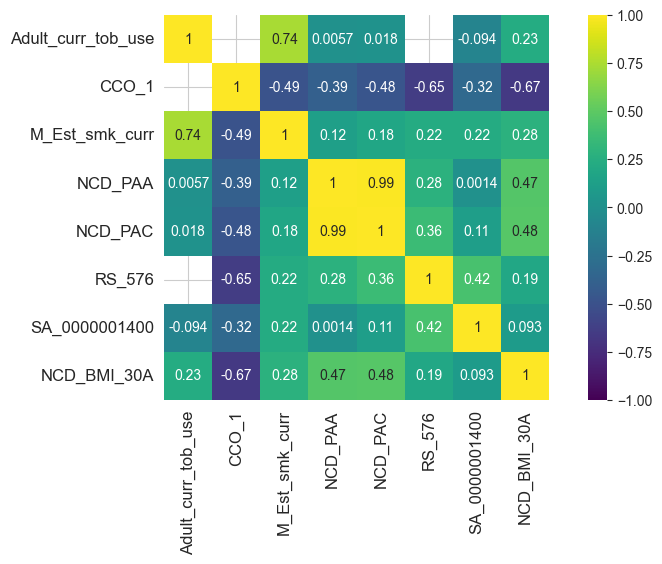

In [10]:
unique_indicators_codes = core_df['IndicatorCode'].unique()

target_indicator = 'NCD_BMI_30A'
indicator_code_df_name_list = []
core_df = core_df[~core_df["Dim1"].isin(["SEX_MLE", "SEX_FMLE", "ALCOHOLTYPE_SA_SPIRITS", "ALCOHOLTYPE_SA_BEER", "ALCOHOLTYPE_SA_WINE", "ALCOHOLTYPE_SA_OTHER_ALCOHOL"])]
core_df_without_dim1 = core_df.drop(columns="Dim1")
core_df_without_dim1 = core_df_without_dim1.drop_duplicates()

for code in unique_indicators_codes:
    if target_indicator != code:
        indicators_data_df = core_df_without_dim1[core_df_without_dim1['IndicatorCode'] == code]
        indicators_data_df = indicators_data_df[['SpatialDim', 'TimeDim', 'IndicatorCode', 'IndicatorName', 'NumericValue', 'Value']]
        indicator_code_df_name_list.append(indicators_data_df)
    else:
        target_indicator_data_df = core_df_without_dim1[core_df_without_dim1['IndicatorCode'] == code] 
        target_indicator_data_df = target_indicator_data_df[['SpatialDim', 'TimeDim', 'IndicatorCode', 'IndicatorName', 'NumericValue', 'Value']]

# 'SpatialDimType', 'ParentLocation', 'ParentLocationCode'

rename_map = {
        "SpatialDim": "CountryCode",
        "TimeDim": "Year"
    }

# Rename columns
target_indicator_data_df.rename(columns={k: v for k, v in rename_map.items() if k in target_indicator_data_df.columns}, inplace=True)
target_indicator_data_df.dropna(subset=["CountryCode", "Year", "NumericValue"], inplace=True)
target_indicator_data_df.to_csv("../data/target_indicator_data_df.csv")

merged_indicators_data_df = target_indicator_data_df.copy()
merged_indicators_data_df["Year"]  = pd.to_numeric(merged_indicators_data_df["Year"], errors="coerce")
merged_indicators_data_df["NumericValue"] = pd.to_numeric(merged_indicators_data_df["NumericValue"], errors="coerce")

new_name = merged_indicators_data_df["IndicatorCode"].iloc[0]  # get value from the row
merged_indicators_data_df.rename(columns={"NumericValue": new_name}, inplace=True)
merged_indicators_data_df.drop(columns="IndicatorCode", inplace=True)
merged_indicators_data_df.drop(columns="IndicatorName", inplace=True)
merged_indicators_data_df.drop(columns="Value", inplace=True)

counter = 1
for indicator_name_df in indicator_code_df_name_list:
    indicator_name_df.rename(columns={k: v for k, v in rename_map.items() if k in indicator_name_df.columns}, inplace=True)
    indicator_name_df.dropna(subset=["CountryCode", "Year", "Value"], inplace=True)
    indicator_name_df["Year"]  = pd.to_numeric(indicator_name_df["Year"], errors="coerce")
    indicator_name_df["NumericValue"] = pd.to_numeric(indicator_name_df["NumericValue"], errors="coerce")
    if not indicator_name_df.empty:
        new_name = indicator_name_df["IndicatorCode"].iloc[0]  # get value from the row
        if indicator_name_df["NumericValue"].isna().all(): 
            indicator_name_df.rename(columns={"Value": new_name}, inplace=True)
            indicator_name_df.drop(columns="NumericValue", inplace=True)
        else:
            indicator_name_df.rename(columns={"NumericValue": new_name}, inplace=True) 
            indicator_name_df.drop(columns="Value", inplace=True)  
        
        indicator_name_df.drop(columns="IndicatorCode", inplace=True)
        indicator_name_df.drop(columns="IndicatorName", inplace=True)  

    merged_indicators_data_df = pd.merge(merged_indicators_data_df, indicator_name_df, on=["CountryCode", "Year"], how="left") 
    counter += 1

merged_indicators_data_df.drop(columns=["IndicatorCode","IndicatorName","NumericValue","Value"], inplace=True)   

merged_indicators_data_df.to_csv("../data/merged_indicators_data_df.csv")

print(merged_indicators_data_df.head(2))


predictors = merged_indicators_data_df.columns[3:]
numerical_predictors = (merged_indicators_data_df[predictors].select_dtypes(include=['number']).columns.to_list())
corr_matrix = merged_indicators_data_df[numerical_predictors + [target_indicator]].corr()
    
plt.figure( figsize=(10, 5))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis")
plt.tick_params(labelsize=12)
plt.show()